In [1]:
%load_ext autoreload
%autoreload 2
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256


In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 1000
n_train = 8000

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 8000 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 2,
    "max_radial": 5,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

# Optimization loop, energies only

In [5]:
device = "cpu"

#if torch.cuda.is_available():
#    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies, radial_spectrum_n_max=8, radial_spectrum_rcut=5)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies, radial_spectrum_n_max=8, radial_spectrum_rcut=5)

do_gradients = False
if do_gradients is True:
    HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
    HYPERS_GRAD["gradients"] = do_gradients
    train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces, radial_spectrum_n_max=12)
    test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces, radial_spectrum_n_max=12)

In [7]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=1000,
    shuffle=True,    
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=200,
    shuffle=False,
    device=device,
)
if do_gradients is True:
    train_dataloader_grad = create_dataloader(
        train_dataset_grad,
        batch_size=50,
        shuffle=True,
        device=device,
    )

    train_dataloader_grad_no_batch = create_dataloader(
        train_dataset_grad,
        batch_size=len(train_dataset_grad),
        shuffle=False,
        device=device,
    )

    test_dataloader_grad = create_dataloader(
        test_dataset_grad,
        batch_size=50,
        shuffle=False,
        device=device,
    )

In [8]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten())**2)

In [9]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        composition, 
        power_spectrum,
        composition_regularizer,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,        
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        self.composition = composition
        
        if composition_regularizer is None:
            self.composition_model = None
        else:
            self.composition_model=LinearModel(
            regularizer=composition_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        
        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        if power_spectrum_regularizer is None:
            self.power_spectrum_model = None
        else:
            self.power_spectrum = power_spectrum
            self.power_spectrum_model = LinearModel(
                regularizer=power_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.combiner = combiner, 
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, frames, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)                
    
        energies, forces = None, None
        
        if self.composition_model is not None:
            energies_cmp, _ = self.composition_model(self.composition(frames))
            energies = energies_cmp
            forces = None
    
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            
            if energies is None:
                energies = energies_rs  
            else:
                energies += energies_rs              
            if forces_rs is not None:
                if forces is None:
                    forces = forces_rs
                else:
                    forces += forces_rs

        if self.power_spectrum_model is not None:
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)

            energies_ps, forces_ps = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
            if energies is None:
                energies = energies_ps
            else:
                energies += energies_ps
            if forces_ps is not None:
                if forces is None:
                    forces = forces_ps
                else:
                    forces += forces_ps
        
        return energies, forces

    def initialize_model_weights(self, frames, radial_spectrum, spherical_expansion, energies, forces=None, seed=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        if self.composition_model is not None:
            self.composition_model.initialize_model_weights(self.composition(frames), energies, forces, seed)
        
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces, seed)
        
        if self.power_spectrum_model is not None:        
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)
            self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces, seed)

In [10]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

composition=CompositionFeatures(all_species, device=device)
power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    composition = composition,
    power_spectrum=power_spectrum, 
    composition_regularizer=[1e-10],
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

if model.optimizable_weights:
    TORCH_REGULARIZER_COMPOSITION = 1e-4
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-1
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e0
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [11]:
model.to(device=device, dtype=torch.get_default_dtype())

MultiBodyOrderModel(
  (sum_structure): SumStructures()
  (composition): CompositionFeatures()
  (composition_model): LinearModel()
  (radial_spectrum_model): LinearModel()
  (power_spectrum): CombinedPowerSpectrum(
    (combiner): CombineSpecies()
    (power_spectrum): PowerSpectrum()
  )
  (power_spectrum_model): LinearModel()
)

In [12]:
if model.random_initial_weights:
    dataloader_initialization = train_dataloader_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

In [13]:
# initialize the model
with torch.no_grad():
    for frames, radial_spectrum, spherical_expansions, energies, _ in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(frames, radial_spectrum, spherical_expansions, energies, seed=12345)
        break

del radial_spectrum, spherical_expansions

In [75]:
torch.cuda.memory_stats()['active_bytes.all.current']/1e6

KeyError: 'active_bytes.all.current'

In [38]:
torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6

KeyError: 'allocated_bytes.all.current'

In [39]:
torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6

KeyError: 'reserved_bytes.all.current'

In [14]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe", history_size=16)

all_losses = []

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [15]:
sum(p.detach().cpu().numpy().nbytes for p in model.parameters())



50600

In [ ]:
assert model.optimizable_weights

for epoch in range(50):
    epoch_start = time.time()

    def single_step():
        optimizer.zero_grad()
        if device=="cuda":
            print(f"mem. before:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
        loss = torch.zeros(size=(1,), device=device)
        for frame, radial_spectrum, spherical_expansions, energies, _ in train_dataloader:
            try:
                predicted, _ = model(frame, radial_spectrum, spherical_expansions, forward_forces=False)
            except:
                if device=="cuda":
                    print(f"mem. during:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
                raise
            loss += loss_mse(predicted, energies)
        loss /= n_train
        if model.composition_model is not None:
            loss += TORCH_REGULARIZER_COMPOSITION * torch.linalg.norm(model.composition_model.weights)
        if model.radial_spectrum_model is not None:
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
        if model.power_spectrum_model is not None:
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

        loss.backward(retain_graph=True)
        print(loss.item(), np.linalg.norm(model.composition_model.weights.grad.numpy()))
        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print("norms", np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.detach().cpu().numpy())
                 )
        print("gradients", 
                  np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.grad.detach().cpu().numpy())
                 )
        with torch.no_grad():
            predicted = []
            reference = []
            for frame, radial_spectrum, spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = model(frame, radial_spectrum, spherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            test_mae = loss_mae(predicted, reference)/n_test

            output.write(f"{n_epochs_total} {loss} {test_mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={test_mae:.4}")
    
    del loss
    n_epochs_total += 1

45.192112860703844 2.9800632982051525
45.17793041475339 2.7921313510206205
45.163474151865906 2.6598379465624844
45.09167547539768 1.7408046014977137
45.08970498219122 1.7060384956465073
45.076115243122175 1.4301060268844734
45.07380370274259 1.393247421030359
45.060560730508655 1.1674357022295236
45.05898243239544 1.1095960767818809
45.05655818510794 1.0770010558406156
45.04230701026066 0.920970684650558
45.0399679080794 0.924144967377314
45.0236175457429 1.0442786317615071
45.01619826684709 1.042772137015486
44.977644199967806 1.1979366009049308
44.9650083877423 1.3365080943374992
44.95813228468729 1.341350386513589
44.916889687329395 1.6373059438910482
44.91319444212763 1.6133121943086217
44.892204655073805 1.507642221473288
44.888465197964614 1.710339770903735
44.88613348218911 1.7474247169200652
44.872797363808374 2.1825758666272876
44.871172086771445 2.167226924906319
44.86055553116702 2.0615604592561048
norms 13.695268304305145 36.298723984589365 22.637204508571088
gradients 2.0

42.31343148930536 1.132746178167012
42.30357176595143 1.2739789691587666
42.30299854775883 1.263604002194417
42.29865838444441 1.1781126185140554
42.29596537694013 1.162866801832759
42.28046998149384 1.1862865597829315
42.275525656547515 1.009527090502895
42.27365048857575 0.9987166162653521
42.2632551274024 1.0149257534060971
42.26211988227986 1.011758013744476
42.253653391278924 1.0038324677266648
42.2489632689298 0.997987081168103
42.24258305497245 0.9927494007749966
42.20841543841476 1.2303418366919172
42.20506624267824 1.2099506751105806
42.187747484424754 1.3220789640552095
42.184770829806794 1.3098703530734894
42.16374038075281 1.2790192573052248
norms 14.029556716824631 36.120923166133196 22.354903630287687
gradients 1.2790192573052248 3.227197543227059 25.130382741187752
epoch 57 took 602.3s, optimizer loss=42.5, test mae=3.376
42.1637403807528 1.2790192573052397
42.159893540493464 1.260540894203451
42.13915015002537 1.300396132330321
42.137759904110425 1.2840187334458737
42.1

TEST MAE: 0.10134405713420923 eV/at


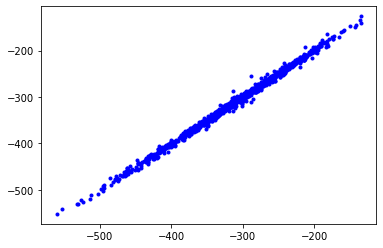

In [17]:
plt.plot(predicted.numpy(), reference.numpy(), 'b.')
print(f"TEST MAE: {test_mae.item()/len(frames[0])} eV/at")

In [18]:
with torch.no_grad():
    tpredicted = []
    treference = []
    for frame, radial_spectrum, spherical_expansions, energies, _ in train_dataloader:
        treference.append(energies)
        predicted_e, _ = model(frame, radial_spectrum, spherical_expansions, forward_forces=False)
        tpredicted.append(predicted_e)

    treference = torch.vstack(treference)
    tpredicted = torch.vstack(tpredicted)
    tmae = loss_mae(tpredicted, treference)/n_train

TRAIN MAE: 0.09187763727954948 eV/at


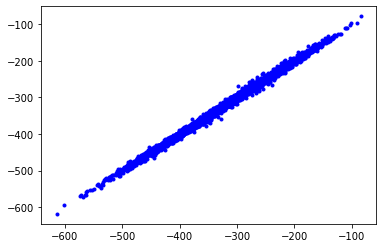

In [19]:
plt.plot(tpredicted, treference, 'b.')
print(f"TRAIN MAE: {tmae.item()/len(frames[0])} eV/at")

# Predicting forces with forward propagation

In [ ]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for frame, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [ ]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [ ]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        HYPERS_GRAD, 
        torch.zeros(2, 1), 
        radial_spectrum_n_max=12,
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [ ]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)